## 1. 모델링

사전설정 (모델 훈련과 예측 모두 공통)

In [1]:
import os

# cols = ["KOSPI", "CR", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI", "INDI", "FOREIGN", "ORG"]
cols = ["KOSPI", "CR", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI"]
len_x_ARMA = 10
len_y_nextday = 20
scale_method = "norm"

# 패키지 캐시 모두 지우기 (tf 등 이전에 남은 가비지가 영향을 미칠 수 있음)
for dir_ in ["/Users/hrdkdh/Documents/GitHub/predict/", "/Users/hrdkdh/venv/"]:
    os.system("find {} | grep -E '(__pycache__|\.pyc$|\pyo$)' | xargs rm -rf".format(dir_))

1-1) 데이터 크롤링

In [2]:
from kospi_predict import Crawler

crawler = Crawler(crawl_page_max=50, perPage=100)
# crawler.crawlData(cols, save=True)
crawler.loadFromSavedFile(cols)
df_crawled = crawler.removeNan()
df_crawled

,date,KOSPI,CR,NASDAQ,DOW,NIKKEI,SHANGHAI
0,2022-02-22,2706.79,1193.0,13381.516,33596.610,26449.61,286.946
1,2022-02-21,2743.80,1192.5,13464.791,33837.895,26910.87,287.511
2,2022-02-18,2744.52,1195.5,13548.066,34079.180,27122.07,286.366
3,2022-02-17,2744.09,1197.5,13716.719,34312.030,27232.87,284.743
4,2022-02-16,2729.68,1198.0,14124.095,34934.270,27460.40,284.624
...,...,...,...,...,...,...,...
2854,2010-07-26,1769.07,1190.0,2296.430,10525.430,9503.66,233.044
2855,2010-07-23,1758.06,1194.0,2269.470,10424.620,9430.96,231.191
2856,2010-07-22,1735.53,1202.0,2245.890,10322.300,9220.88,231.672
2857,2010-07-21,1748.78,1205.5,2187.330,10120.530,9278.83,229.873


1-2. 데이터 전처리

In [3]:
from kospi_predict import DataPreprocessor

dpp = DataPreprocessor(df_crawled, cols, scale_method)
# dpp.removeOutlier()
dpp.sortByDate()
dpp.scalingForModeling()
dpp.makeTargetXs(len_x_ARMA)
dpp.makeTargetYs(len_y_nextday)
dpp.cutoffData(len_x_ARMA, len_y_nextday)
# dpp.cutoffData(1000, len_y_nextday)
dpp.splitData()
dpp.df_cutoff

,date,KOSPI,CR,NASDAQ,DOW,NIKKEI,SHANGHAI,KOSPI_scaled,CR_scaled,NASDAQ_scaled,...,Y_KOSPI_scaled_nextday_11,Y_KOSPI_scaled_nextday_12,Y_KOSPI_scaled_nextday_13,Y_KOSPI_scaled_nextday_14,Y_KOSPI_scaled_nextday_15,Y_KOSPI_scaled_nextday_16,Y_KOSPI_scaled_nextday_17,Y_KOSPI_scaled_nextday_18,Y_KOSPI_scaled_nextday_19,Y_KOSPI_scaled_nextday_20
0,2010-08-04,1789.26,1171.0,2303.570,10680.43,9489.34,239.530,-1.077138,0.886822,-1.126827,...,-1.104294,-1.115868,-1.137971,-1.158240,-1.230902,-1.245101,-1.245665,-1.159369,-1.208431,-1.146497
1,2010-08-05,1783.86,1165.0,2293.060,10674.98,9653.92,239.970,-1.092381,0.759258,-1.129811,...,-1.115868,-1.137971,-1.158240,-1.230902,-1.245101,-1.245665,-1.159369,-1.208431,-1.146497,-1.115332
2,2010-08-06,1783.83,1164.0,2288.470,10653.56,9642.12,243.550,-1.092466,0.737998,-1.131115,...,-1.137971,-1.158240,-1.230902,-1.245101,-1.245665,-1.159369,-1.208431,-1.146497,-1.115332,-1.103221
3,2010-08-09,1790.17,1160.0,2305.690,10698.75,9572.49,246.592,-1.074569,0.652955,-1.126225,...,-1.158240,-1.230902,-1.245101,-1.245665,-1.159369,-1.208431,-1.146497,-1.115332,-1.103221,-1.068217
4,2010-08-10,1781.13,1169.0,2277.170,10644.25,9551.05,241.967,-1.100088,0.844301,-1.134324,...,-1.230902,-1.245101,-1.245665,-1.159369,-1.208431,-1.146497,-1.115332,-1.103221,-1.068217,-1.081428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,2022-01-14,2921.92,1188.0,14893.753,35911.81,28124.28,286.838,2.120263,1.248253,2.448775,...,1.515877,1.635682,1.621003,1.624983,1.688160,1.696854,1.628483,1.506449,1.427577,1.577586
2824,2022-01-17,2890.10,1192.5,14700.325,35640.14,28333.52,287.162,2.030438,1.343926,2.393842,...,1.635682,1.621003,1.624983,1.688160,1.696854,1.628483,1.506449,1.427577,1.577586,1.618264
2825,2022-01-18,2864.24,1192.5,14506.897,35368.47,28257.25,287.007,1.957437,1.343926,2.338909,...,1.621003,1.624983,1.688160,1.696854,1.628483,1.506449,1.427577,1.577586,1.618264,1.619478
2826,2022-01-19,2842.28,1191.0,14340.255,35028.65,27467.23,286.982,1.895446,1.312035,2.291582,...,1.624983,1.688160,1.696854,1.628483,1.506449,1.427577,1.577586,1.618264,1.619478,1.617446


1-3) 모델 훈련하고 생성

2022-02-24 18:46:42.227493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-24 18:46:42.227605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-24 18:46:42.320202: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 1200)              145200    
                                                                 
 dense_1 (Dense)             (None, 1200)              1441200   
                                                                 
 dense_2 (Dense)             (None, 1200)              1441200   
                                                                 
 dense_3 (Dense)             (None, 1200)              1441200   
                                                                 
 dense_4 (Dense)             (None, 20)                24020     
                                             

2022-02-24 18:46:42.566833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 18:46:43.933386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


모델 생성 완료599/600(100%) loss : 0.0026, mae : 0.0314, mse : 0.0026 / val_loss : 0.0096, val_mae : 0.0631, val_mse : 0.0096                              
모델 저장 완료


2022-02-24 18:55:16.566648: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model/assets


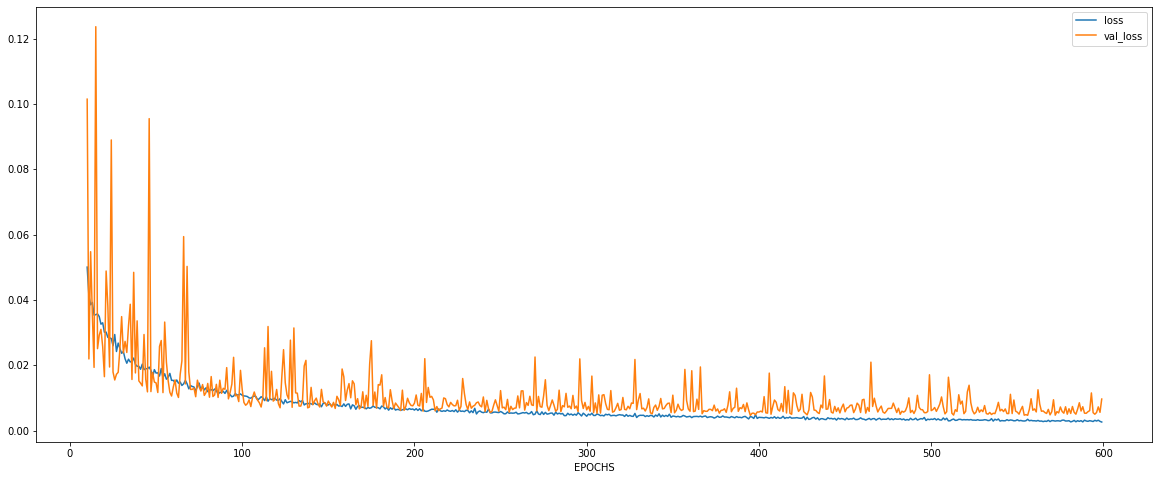

2022-02-24 18:55:17.336172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


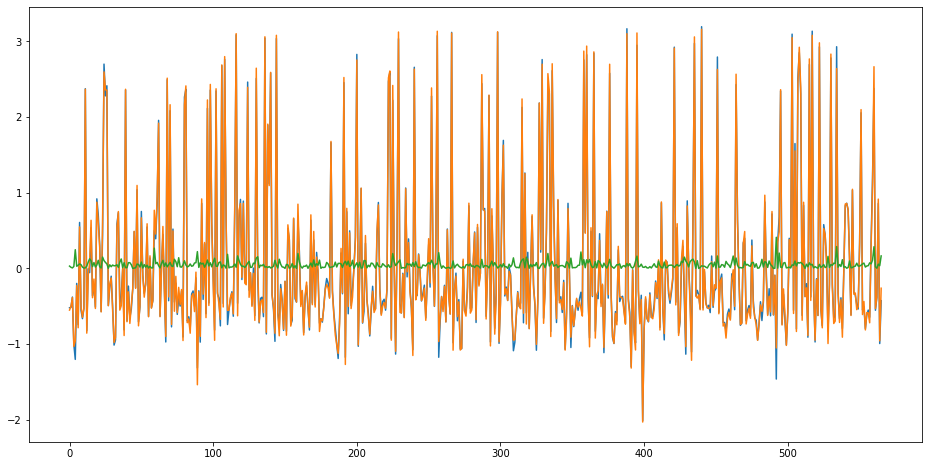

In [4]:
from kospi_predict import ModelMaker

maker = ModelMaker(dpp.y_list, dpp.df_train, dpp.df_test)
maker.makeModel(EPOCHS=600, history_plot_cutoff=30, learning_rate=0.0008)
maker.validateModel(y_no=0)

## 2. 최근 데이터로 20일 간의 KOSPI 지수 예측

2-1) 데이터 수집

In [2]:
from kospi_predict import Crawler

#예측을 위해서는 현재기준 이전 10일간의 데이터만 있으면 됨 (len_x_ARMA가 10일때)
crawler_pred = Crawler(crawl_page_max=1, perPage=50) #이전 추세도 볼겸 넉넉히 수집
crawler_pred.crawlData(cols)
df_crawled_pred = crawler_pred.removeNan()
df_crawled_pred


KOSPI : 1번째 페이지 데이터 수집중...
CR : 1번째 페이지 데이터 수집중...
NASDAQ : 1번째 페이지 데이터 수집중...
DOW : 1번째 페이지 데이터 수집중...
NIKKEI : 1번째 페이지 데이터 수집중...


,date,KOSPI,CR,NASDAQ,DOW,NIKKEI,SHANGHAI
0,2022-02-22,2706.79,1193.0,13381.516,33596.610,26449.610,286.946
1,2022-02-21,2743.80,1192.5,13464.791,33837.895,26910.870,287.511
2,2022-02-18,2744.52,1195.5,13548.066,34079.180,27122.070,286.366
3,2022-02-17,2744.09,1197.5,13716.719,34312.030,27232.870,284.743
4,2022-02-16,2729.68,1198.0,14124.095,34934.270,27460.400,284.624
5,2022-02-15,2676.54,1197.5,14139.757,34988.840,26865.190,283.019
6,2022-02-14,2704.48,1197.5,13790.919,34566.170,27079.590,283.258
7,2022-02-11,2747.71,1197.0,13791.154,34738.060,27387.835,285.216
8,2022-02-10,2771.93,1196.5,14185.641,35241.590,27696.080,285.679
9,2022-02-09,2768.85,1196.0,14490.373,35768.060,27579.870,285.237


2-2) 데이터 전처리

In [3]:
from kospi_predict import DataPreprocessor

#아래는 예측을 위한 전처리
dpp_pred = DataPreprocessor(df_crawled_pred, cols, scale_method)
dpp_pred.sortByDate()
dpp_pred.scalingForPredict()
dpp_pred.makeTargetXs(len_x_ARMA)
dpp_pred.cutoffData(len_x_ARMA, 0)

2-3) 예측

2022-02-24 18:59:38.176023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-24 18:59:38.176134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-24 18:59:38.648453: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-24 18:59:38.681294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


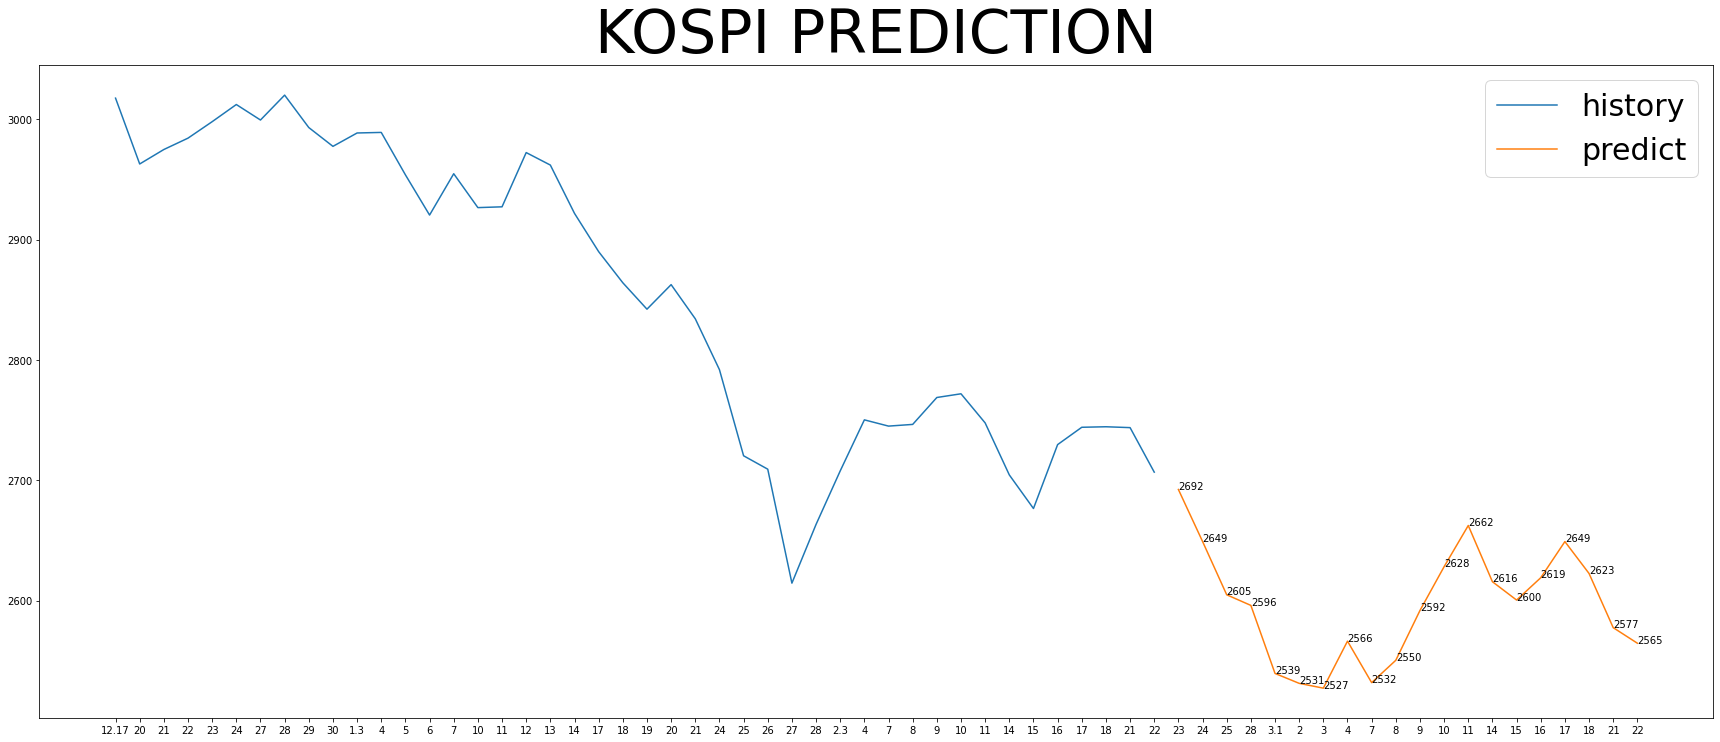

In [4]:
from kospi_predict import Predictor

#2.18 기준으로 20일 뒤까지 예측하고 시각화

predictor = Predictor(dpp_pred.df, scaled=True, scale_method = scale_method)
predictor.predict()
predictor.showPredictionPlot()

In [5]:
len(predictor.x_cols)
# predictor.saveModelToJS()

120